# SVD facial recognition

This software uses the singular value decomposition (SVD) of a matrix to implement a facial recognition system.

This software can be used with any dataset with slight modifications, but it was designed and tested using the FaceScrub dataset. In order to get started, make sure to run the command

```
python3 download_faces.py --crop_face facescrub_actors.txt actors
```
and similarly for the actresses file. After the download is complete, each one should have a subfolder called `faces`. Move these to a folder called `./faces/actors` or `./faces/actresses`.

In [1]:
import os
from collections import defaultdict

import numpy as np
from PIL import Image
from imageio import imread
from matplotlib import pyplot as plt
from scipy import linalg as la

%matplotlib inline

In [2]:
# Global settings
# Note that if these numbers are set too high, the kernel may crash under the load
num_actors = 30  # How many actors to sample (should be an even number)
num_images = 30  # Maximum number of pictures from each actor to go into the SVD
num_test_images = 7  # Number of test images per actor for the matching algorithm
W = H = 300  # Width and height of images (everything will be scaled to these dimensions)
show_images = True
separate_genders = True  # If True, keep separate tables for each gender. If False, mix them all together.
debug = False

In [3]:
def load_image(path):
    """Given a path, read the image, scale it, and return as a flattened vector"""
    im_data = imread(path, as_gray=True)
    scaled_image = Image.fromarray(im_data).resize((W, H), Image.LINEAR)
    return np.ravel(np.array(scaled_image))
    

def load_all_faces(base_path):
    total_faces = []
    names = []  # The names associated with the above 
    test_faces = defaultdict(list)  # Excluded faces for testing purposes

    number_subjects = 0
    for (path, directory, files) in os.walk(base_path):  # Loop through folders
        if number_subjects >= num_actors // 2: break  # Only go through so many actors
        files = [f for f in files if f[-4:].lower() in ('.jpg', 'jpeg')]  # Only worry about JPG files
        if not files: continue

        name = os.path.basename(os.path.normpath(path)).replace('_', ' ')  # Actor's name
        selection = np.random.choice(files, min(num_images + num_test_images, len(files)), replace=False)

        for i, file in enumerate(selection):
            img = load_image(os.path.join(path, file))
            if i < num_test_images:
                test_faces[name].append(img)
            else:
                total_faces.append(img)
                names.append(name)
        number_subjects += 1

    return np.array(total_faces).T, names, test_faces

def get_random_faces(k):
    """Return k people randomly selected from those we set aside for testing purposes."""
    names = list(test_faces.keys())
    n = len(names)
    if k > n:
        k = n
    for i in np.random.choice(range(n), k, replace=False):
        name = names[i]
        yield test_faces[name], name

In [4]:
def show_image(img, label=None):
    """Given a picture, display it."""
    img = np.resize(img, (H, H))
    plt.axis('off')
    plt.title(label or '')
    plt.imshow(img, cmap='gray')

In [5]:
face_matrix_m, names_m, test_faces_m = load_all_faces('./faces/actors')
face_matrix_f, names_f, test_faces_f = load_all_faces('./faces/actresses')

# Combine data for each gender
face_matrix = np.column_stack((face_matrix_m, face_matrix_f))
names = names_m + names_f
test_faces = dict(**test_faces_m, **test_faces_f)

In [6]:
def get_gender(name):
    if name in names_m:
        return True
    elif name in names_f:
        return False
    raise ValueError(f'Name {name} not in dataset!')

In [7]:
if separate_genders:
    # Compute average and shift all images by the average
    mu_m = np.mean(face_matrix_m, axis=1)
    shifted_faces_m = face_matrix_m - np.vstack(mu_m)

    mu_f = np.mean(face_matrix_f, axis=1)
    shifted_faces_f = face_matrix_f - np.vstack(mu_f)


    # Compute SVD. We only care about the eigenvectors. 
    # TODO: Look into more efficient ways of computing eigenvectors for largest 
    #   eigenvalues. We only need the first 100 or so at any rate.
    U_m, _, _ = la.svd(shifted_faces_m, full_matrices=False)
    U_f, _, _ = la.svd(shifted_faces_f, full_matrices=False)
else:
    mu = np.mean(face_matrix, axis=1)
    shifted_faces = face_matrix - np.vstack(mu)
    U, _, _ = la.svd(shifted_faces, full_matrices=False)

In [8]:
def project(face, U, s):
    return U[:,:s].T @ face

def find_nearest(face, male=True, s=50):
    if separate_genders:
        if male:
            shifted = shifted_faces_m
            muv = mu_m
            Uv = U_m
        else:
            shifted = shifted_faces_f
            muv = mu_f
            Uv = U_f
    else:
        shifted = shifted_faces
        muv = mu
        Uv = U
    Fhat = project(shifted, Uv, s)
    face_projection = project(face - muv, Uv, s)
    dist = np.linalg.norm(Fhat - np.vstack(face_projection), axis=0)
    return np.argmin(dist), np.min(dist)

def find_nearest_many(faces, male=True):
    matches = []
    distances = []
    for face in faces:
        match, dist = find_nearest(face, male=male)
        matches.append(match)
        distances.append(dist)

    best_match = max(set(matches), key=matches.count)
    distance = 0
    for dist, match in zip(distances, matches):
        if match == best_match:
            distance += dist
    distance /= (W * H)  # Normalize
    return best_match, 1 - distance

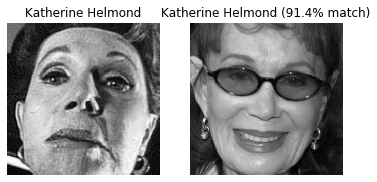

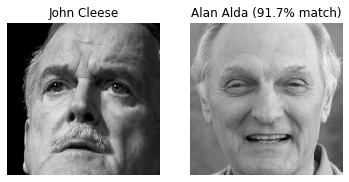

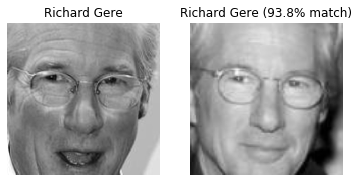

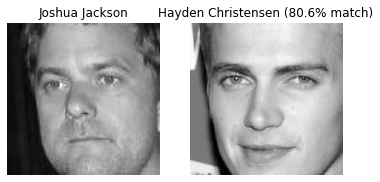

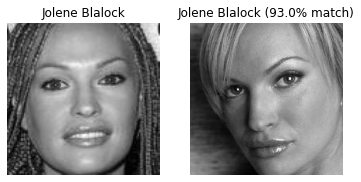

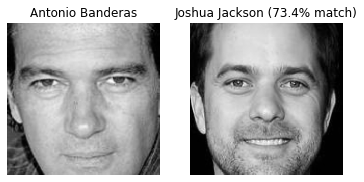

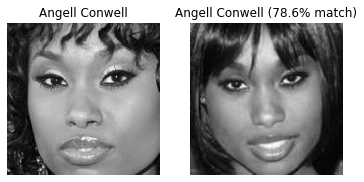

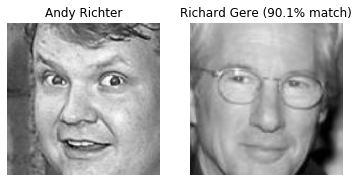

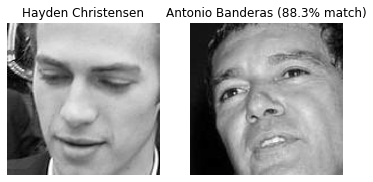

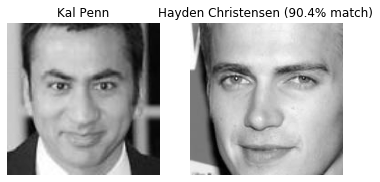

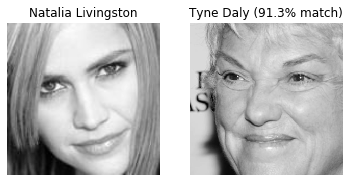

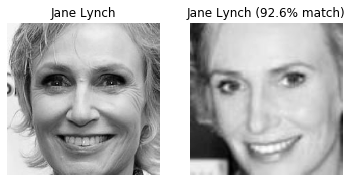

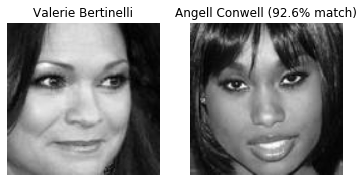

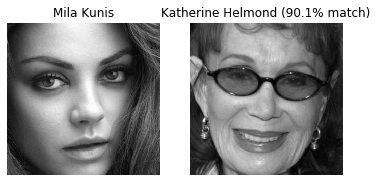

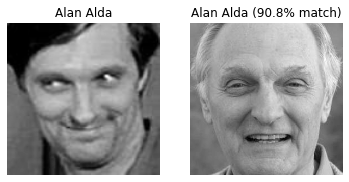

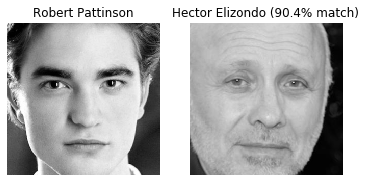

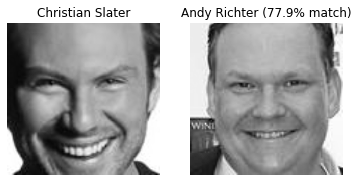

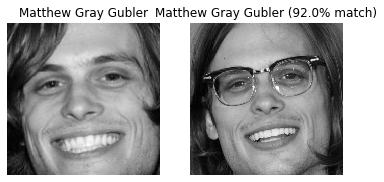

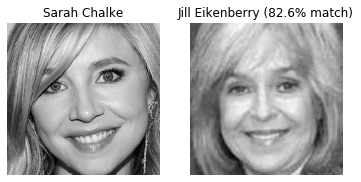

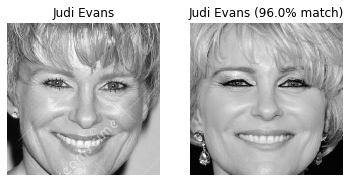

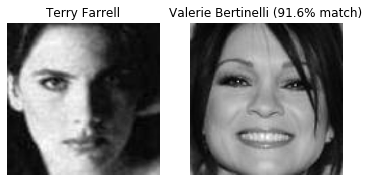

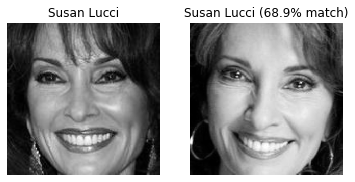

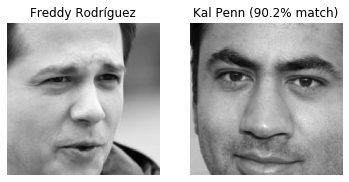

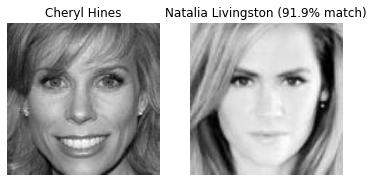

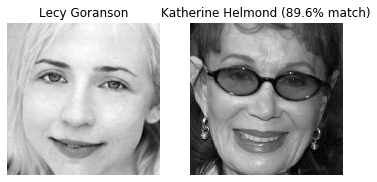

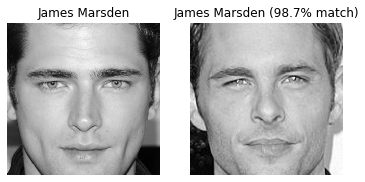

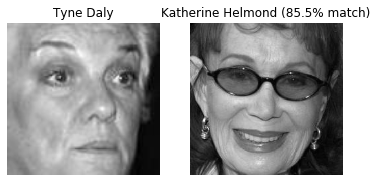

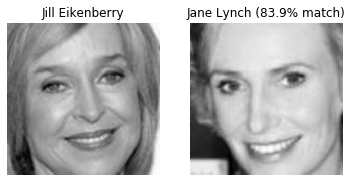

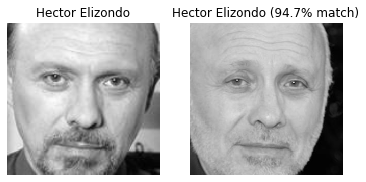

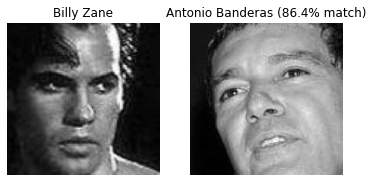

In [9]:
k = min(50, len(test_faces.keys()))
correct = []
for faces, name in get_random_faces(k):
    if separate_genders:
        gender = get_gender(name)
        best_match, confidence = find_nearest_many(faces, male=gender)
        if gender:
            name_match = names_m[best_match]
        else:
            name_match = names_f[best_match]
    else:
        best_match, confidence = find_nearest_many(faces)
        name_match = names[best_match]
    
    if name_match == name:
        correct.append(name)
    
    if show_images:
        plt.subplot(1, 2, 1)
        show_image(faces[0], name)
        plt.subplot(1, 2, 2)
        if separate_genders:
            if gender:
                indx = names_m.index(name_match)
                img = face_matrix_m[:,indx]
            else:
                indx = names_f.index(name_match)
                img = face_matrix_f[:,indx]
        else:
            indx = names.index(name_match)
            img = face_matrix[:,indx]
        show_image(img, f'{name_match} ({round(confidence * 100, 1)}% match)')
        plt.show()

In [10]:
print('Accuracy:', round(len(correct) / k * 100), '%')
for name in correct:
    print('Match:', name)

Accuracy: 37 %
Match: Katherine Helmond
Match: Richard Gere
Match: Jolene Blalock
Match: Angell Conwell
Match: Jane Lynch
Match: Alan Alda
Match: Matthew Gray Gubler
Match: Judi Evans
Match: Susan Lucci
Match: James Marsden
Match: Hector Elizondo
